In [1]:
import dissociation as ds

import jax
import jax.numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, explained_variance_score

import itertools
from functools import partial

plt.style.use("./style.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
in_dim = 6
hidden_dim = 16
out_dim = 2
p = 4

steps = 101
runs = 10

In [3]:
def get_name(f1, f2):
    return f1.__name__.split("_")[1].upper() + "$\\rightarrow$" + f2.__name__.split("_")[1].upper()
    
names = [get_name(f1, f2) for f1, f2 in  itertools.product([ds.walk_lss, ds.walk_mwns, ds.walk_mrns], repeat=2)]

In [4]:
def linear_predictivity(hs1, hs2):
    linear_model = Ridge()
    lm = linear_model.fit(hs1.T, hs2.T).predict(hs1.T)
    return r2_score(hs2.T, lm)

def compute_rdm(activations):
    correlation_distance = pdist(activations.T, metric='euclidean')
    return squareform(correlation_distance)

def compare_rdms(rdm1, rdm2):
    triu = np.triu_indices_from(rdm1, k=1)
    return pearsonr(rdm1[triu], rdm2[triu]).correlation

def rsa(hs1, hs2):
    return compare_rdms(compute_rdm(hs1), compute_rdm(hs2))

In [5]:
rss = {"across": {n: [] for n in names}, "within": {n: [] for n in names}}
corss = {"across": {n: [] for n in names}, "within": {n: [] for n in names}}

keys = jax.random.split(jax.random.PRNGKey(0), runs*2 + 1)
rng, keys1, keys2 = keys[0], keys[1:runs+1], keys[1+runs:]

multiple_tasks = jax.vmap(ds.utils.random_regression_task, in_axes=(0, None, None, None))
t1 = multiple_tasks(keys1, in_dim, out_dim, p)
t2 = multiple_tasks(keys2, in_dim, out_dim, p)

fs = [ds.walk_lss, ds.walk_mwns, ds.walk_mrns]
fs = [jax.vmap(f, in_axes=(0, 0, 0, None, None)) for f in fs]

for i, (t1, t2) in enumerate([(t1, t2), (t1, t1)]):
    print("====>")
    key = "across" if i == 0 else "within"
    for f1, f2 in itertools.product(fs, repeat=2):
        print(f1, f2)
        keys = jax.random.split(rng, runs*2 + 1)
        rng, keys1, keys2 = keys[0], keys[1:runs+1], keys[1+runs:]
        w1s1, _ = f1(keys1, t1[0], t1[1], hidden_dim, steps)
        w1s2, _ = f2(keys2, t2[0], t2[1], hidden_dim, steps)

        hs1 = np.einsum("rthi,rin->rthn", w1s1, t1[0])
        hs2 = np.einsum("rthi,rin->rthn", w1s2, t2[0])

        predictivities = [
            linear_predictivity(hs1[i, t], hs2[i, t])
            for i in range(runs)
            for t in range(steps)
        ]
        
        rss[key][get_name(f1, f2)] = np.array(predictivities).reshape(runs, steps)

        rsas = [
            rsa(hs1[i, t], hs2[i, t])
            for i in range(runs)
            for t in range(steps)
        ]

        corss[key][get_name(f1, f2)] = np.array(rsas).reshape(runs, steps)

====>
<function walk_lss at 0x7cffbd558f40> <function walk_lss at 0x7cffbd558f40>
<function walk_lss at 0x7cffbd558f40> <function walk_mwns at 0x7cffbd5599e0>
<function walk_lss at 0x7cffbd558f40> <function walk_mrns at 0x7cffbd559d00>
<function walk_mwns at 0x7cffbd5599e0> <function walk_lss at 0x7cffbd558f40>
<function walk_mwns at 0x7cffbd5599e0> <function walk_mwns at 0x7cffbd5599e0>
<function walk_mwns at 0x7cffbd5599e0> <function walk_mrns at 0x7cffbd559d00>
<function walk_mrns at 0x7cffbd559d00> <function walk_lss at 0x7cffbd558f40>
<function walk_mrns at 0x7cffbd559d00> <function walk_mwns at 0x7cffbd5599e0>
<function walk_mrns at 0x7cffbd559d00> <function walk_mrns at 0x7cffbd559d00>
====>
<function walk_lss at 0x7cffbd558f40> <function walk_lss at 0x7cffbd558f40>
<function walk_lss at 0x7cffbd558f40> <function walk_mwns at 0x7cffbd5599e0>
<function walk_lss at 0x7cffbd558f40> <function walk_mrns at 0x7cffbd559d00>
<function walk_mwns at 0x7cffbd5599e0> <function walk_lss at 0

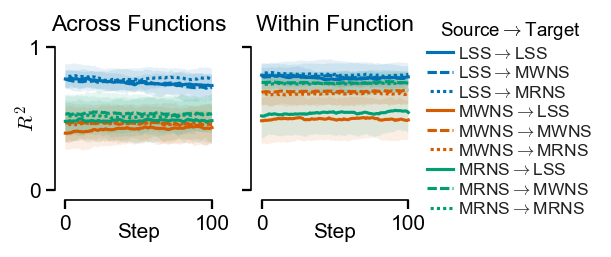

In [6]:
lss = ["-", (0, (3, 1)), (1, (1, 1))]

fig, axs = plt.subplots(1, 2, figsize=(2.2*1.8, 1.6))
axs = axs.flatten()

for i, (k, v) in enumerate(rss.items()):
    ax = axs[i]
    for j, name in enumerate(names):
        rss_ = np.mean(np.asarray(v[name]), axis=0)
        std = np.std(np.asarray(v[name]), axis=0)
        ax.plot(rss_, label=name, color=colors[j//3], linestyle=lss[j%3], zorder=2)
        ax.fill_between(range(rss_.shape[0]), rss_ - std, rss_ + std, color=colors[j//3],
                        alpha=0.1, edgecolor="none", zorder=0)
    
    ax.set_ylim(0., 1.)
    ax.set_yticks([0, 1])
    ax.set_xticks([0, steps - 1])
    if i == 1:
        ax.set_yticklabels([])
    else:
        ax.set_yticklabels([0, 1])
    ax.set_xlabel("Step", labelpad=-5)
 
axs[0].set_title("Across Functions")
axs[1].set_title("Within Function")

axs[0].set_ylabel("$R^2$", labelpad=-5)

axs[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Source$\\rightarrow$Target",
              handlelength=1.5, title_fontsize=9.)

plt.savefig("../figures/fig4/linear-predictivity.svg", dpi=300)

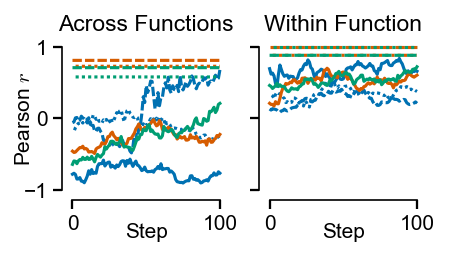

In [7]:
n = 9

fig, axs = plt.subplots(1, 2, figsize=(1.6*1.8, 1.6))
axs = axs.flatten()

for i, (k, vs) in enumerate(corss.items()):
    ax = axs[i]
    for j, name in enumerate(names):
        if len(vs[name]) == 0:
            continue
        data = np.asarray(vs[name][n])
        ax.plot(data, label=name, color=colors[j//3], linestyle=lss[j%3])
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Step", labelpad=-5)

axs[0].set_ylabel("Pearson $r$", labelpad=-5)
axs[0].set_title("Across Functions")
axs[1].set_title("Within Function")
axs[1].set_yticklabels([])

plt.savefig("../figures/fig4/rsa.svg", dpi=300)

In [8]:
rng, key = jax.random.split(jax.random.PRNGKey(0), 2)

steps = 501
xs, ys = ds.random_regression_task(key, in_dim, out_dim, p)

decoding_performance = []
keys = jax.random.split(rng, 3)
for i, f in enumerate([ds.walk_lss, ds.walk_mrns, ds.walk_mwns]):
    print(f)
    w1s, w2s = f(keys[i], xs, ys, hidden_dim, steps)
    w2_star = ys @ xs.T @ w1s[0].T @ np.linalg.pinv(w1s[0] @ xs @ xs.T @ w1s[0].T)
    
    ys_ = np.einsum("oh,thi,in->ton", w2_star, w1s, xs)
    decoding_performance.append(0.5 / p * np.linalg.norm(ys_ - ys, axis=(1, 2))**2)

<PjitFunction of <function walk_lss at 0x7d0003076660>>
<PjitFunction of <function walk_mrns at 0x7d0003076840>>
<PjitFunction of <function walk_mwns at 0x7d0003076a20>>


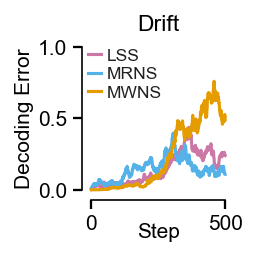

In [9]:
labels = [
    "LSS",
    "MRNS",
    "MWNS"
]
fig, ax = plt.subplots(figsize=(1.6, 1.6))
for i in range(3):
    ax.plot(decoding_performance[i], label=labels[i], c=colors[4+i])

ax.set_title("Drift")
ax.set_xlabel("Step", labelpad=-5)
ax.set_ylabel("Decoding Error")
ax.set_ylim(0, 1.)
ax.set_yticks([0, 0.5, 1.])

ax.legend(loc=(0.025, 0.6), frameon=True, edgecolor="w", facecolor="w", framealpha=0.6, borderpad=0.1)
plt.savefig("../figures/fig4/representational-drift.svg", dpi=300)

In [10]:
steps = 101
n = 500000

rng, key = jax.random.split(jax.random.PRNGKey(0), 2)
xs, ys = ds.random_regression_task(key, in_dim, out_dim, p)

sigma = 1.
sigma_1 = sigma * 1. / np.sqrt(np.linalg.norm(xs)**2)
sigma_2 = sigma * 1. / np.sqrt(out_dim)

rng, key1, key2 = jax.random.split(rng, 3)
fs1 = [ds.walk_gls, ds.walk_lss, ds.walk_mrns, ds.walk_mwns]
fs2 = [
    partial(ds.input_noise_sensitivity, key=key1, sigma_x=sigma, p=n),
    partial(ds.input_noise_sensitivity_theory, sigma_x=sigma),
    partial(ds.parameter_noise_sensitivity, key=key2, sigma_1=sigma_1, sigma_2=sigma_2, p=n),
    partial(ds.parameter_noise_sensitivity_theory, sigma_1=sigma_1, sigma_2=sigma_2),
]

input_numerical = []
input_theory = []
parameter_numerical = []
parameter_theory = []
for f in fs1:
    print(f)

    rng, key = jax.random.split(rng, 2)
    w1s, w2s = f(key, xs, ys, hidden_dim, steps)
    for i, buffer in enumerate([input_numerical, input_theory, parameter_numerical, parameter_theory]):
        buffer.append(np.asarray([fs2[i](w1=w1s[t], w2=w2s[t], xs=xs, ys=ys) for t in range(steps)]))

<PjitFunction of <function walk_gls at 0x7d00030760c0>>
<PjitFunction of <function walk_lss at 0x7d0003076660>>
<PjitFunction of <function walk_mrns at 0x7d0003076840>>
<PjitFunction of <function walk_mwns at 0x7d0003076a20>>


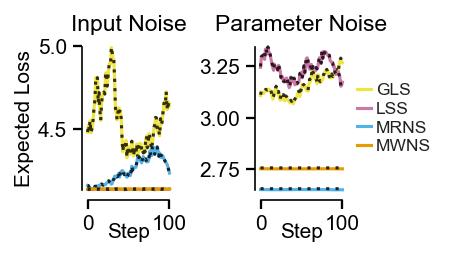

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(1.6*1.8, 1.6))
ax = axs[0]
for i in range(4):
    ax.plot(input_numerical[i], c=colors[i+3])
    if i == 3:
        ax.plot(input_theory[i], c="k", linestyle=(0, (1, 2)), alpha=0.8, label="Theory")
    else:
        ax.plot(input_theory[i], c="k", linestyle=(0, (1, 2)), alpha=0.8)
ax.set_title("Input Noise")
ax.set_xlabel("Step", labelpad=-5)
ax.set_ylabel("Expected Loss")

ax = axs[1]
for i in range(4):
    ax.plot(parameter_numerical[i], label=fs1[i].__name__.split("_")[1].upper(), c=colors[i+3])
    ax.plot(parameter_theory[i], c="k", linestyle=(0, (1, 2)), alpha=0.8)
ax.set_title("Parameter Noise")
ax.set_xlabel("Step", labelpad=-5)
axs[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

for i in range(2):
    axs[i].set_xticks([0, steps-1])

plt.savefig("../figures/fig4/noise.svg", dpi=300)